# Matrix Factorization with PyTorch

In [ ]:
#!pip install torchviz

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
#from torchviz import make_dot
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error



In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

### Synthetic Dataset

In [ ]:
import numpy as np
import pandas as pd

def generate_synthetic_dataset(num_users, num_items, latent_factors, noise_level):


    # Generate random user and item factor matrices
    #user_factors = np.random.rand(num_users, latent_factors)
    #item_factors = np.random.rand(num_items, latent_factors)

    # Latent factors
    user_factors = np.random.normal(scale=1, size=(num_users, latent_factors))
    item_factors = np.random.normal(scale=1, size=(num_items, latent_factors))

    rating_matrix = np.dot(user_factors, item_factors.T)

    # Introduce noise
    rating_matrix += np.random.normal(scale=noise_level, size=rating_matrix.shape)

    # Clip ratings to a reasonable range (e.g., 1 to 5)
    #rating_matrix = np.clip(rating_matrix, 1, 5)

    # Flatten into user-item-rating triplets
    users, items = np.where(~np.isnan(rating_matrix))
    ratings = rating_matrix[users, items]
    rating_matrix = np.dot(user_factors, item_factors.T)

    df = pd.DataFrame({'userId': users, 'movieId': items, 'rating': ratings})

    return df



In [ ]:

# Example usage:
num_users = 1000
num_movies = 500
latent_factors = 10
noise_level = 0.5


data = generate_synthetic_dataset(num_users, num_movies, latent_factors, noise_level)
data.head()

,userId,movieId,rating
0,0,0,-1.907610
1,0,1,-1.329440
2,0,2,1.979575
3,0,3,-0.421649
4,0,4,3.679908


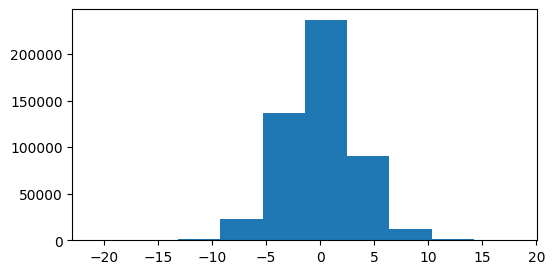

In [ ]:
plt.figure(figsize=(6, 3))
plt.hist(data.rating);

In [21]:
# Load MovieLens Small dataset
data = pd.read_csv("ratings.csv", sep=",")
#data = pd.read_csv("../../datasets/ml-latest-small/ratings.csv", sep=",")
#data = pd.read_csv("../../datasets/ml-1m/ratings.csv", sep=",", names=["userId","movieId","rating","timestamp"])

#data = pd.read_csv("ratings.csv", sep=",")
#data = pd.read_csv("drive/MyDrive/datasets/ml-32m/ratings.csv", sep=",")
print(data.shape)
data.head()

(1000209, 4)


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [22]:
# Map user and movie IDs to unique consecutive indices starting from 0.
# This is needed because embedding layer indexes start from 0
user_ids = data['userId'].unique()
movie_ids = data['movieId'].unique()

user_mapping = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_mapping = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

data['userId'] = data['userId'].map(user_mapping)
data['movieId'] = data['movieId'].map(movie_mapping)

num_users = len(user_ids)
num_movies = len(movie_ids)

In [5]:
# Define the matrix factorization model
class MatrixFactorizationWithBiasModel(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=5):
        super(MatrixFactorizationWithBiasModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)

        # Global mean bias
        self.global_bias = nn.Parameter(torch.tensor(0.0))

        # User bias: One bias term per user
        self.user_bias = nn.Embedding(num_users, 1)
        nn.init.constant_(self.user_bias.weight, 0)  # Initialize biases to zero

        # Item bias: One bias term per item
        self.item_bias = nn.Embedding(num_movies, 1)
        nn.init.constant_(self.item_bias.weight, 0)  # Initialize biases to zero

    def forward(self, X):
        n = X.shape[0]
        #prediction = torch.zeros((n), dtype=torch.float)

        # forward function takes the indices of some users and movies and make
        # prediction by find the dot products of the corresponding users and movies
        user_embedding = self.user_embedding(X[:,0])
        movie_embedding = self.movie_embedding(X[:,1])
        # below line calculates the dot product between embedding vectors
        dot_product = torch.sum(user_embedding * movie_embedding, dim=1)
        # Add biases
        user_b = self.user_bias(X[:,0]).squeeze()
        item_b = self.item_bias(X[:,1]).squeeze()
        prediction = self.global_bias + user_b + item_b + dot_product


        return prediction

In [6]:
# Define the matrix factorization model
class MatrixFactorizationModel(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=5):
        super(MatrixFactorizationModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)


    def forward(self, X):
        # forward function takes the indices of some users and movies and make
        # prediction by find the dot products of the corresponding users and movies
        user_embedding = self.user_embedding(X[:,0])
        movie_embedding = self.movie_embedding(X[:,1])
        # below line calculates the dot product between embedding vectors
        dot_product = torch.sum(user_embedding * movie_embedding, dim=1)
        prediction = dot_product

        return prediction

In [7]:
# Define the matrix factorization model
class BiasOnlyModel(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=5):
        super(BiasOnlyModel, self).__init__()

        # Global mean bias
        self.global_bias = nn.Parameter(torch.tensor(0.0))

        # User bias: One bias term per user
        self.user_bias = nn.Embedding(num_users, 1)
        nn.init.constant_(self.user_bias.weight, 0)  # Initialize biases to zero

        # Item bias: One bias term per item
        self.item_bias = nn.Embedding(num_movies, 1)
        nn.init.constant_(self.item_bias.weight, 0)  # Initialize biases to zero

    def forward(self, X):
        user_b = self.user_bias(X[:,0]).squeeze()
        item_b = self.item_bias(X[:,1]).squeeze()
        prediction = self.global_bias + user_b + item_b

        return prediction

In [8]:
class NeuralCollaborativeFilteringModel(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=5, hidden_dim=16):
        super(NeuralCollaborativeFilteringModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)

        # Global mean bias
        self.global_bias = nn.Parameter(torch.tensor(0.0))

        # User bias: One bias term per user
        self.user_bias = nn.Embedding(num_users, 1)
        nn.init.constant_(self.user_bias.weight, 0)  # Initialize biases to zero

        # Item bias: One bias term per item
        self.item_bias = nn.Embedding(num_movies, 1)
        nn.init.constant_(self.item_bias.weight, 0)  # Initialize biases to zero

        # Learnable interaction function (Feedforward Neural Network)
        self.interaction_layer = nn.Sequential(
            nn.Linear(embedding_size * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, X):
        n = X.shape[0]

        # Get user and item embeddings
        user_embedding = self.user_embedding(X[:, 0])
        movie_embedding = self.movie_embedding(X[:, 1])

        # Concatenate user and item embeddings
        interaction_input = torch.cat([user_embedding, movie_embedding], dim=1)

        # Learnable interaction
        interaction_score = self.interaction_layer(interaction_input).squeeze()

        # Add biases
        user_b = self.user_bias(X[:, 0]).squeeze()
        item_b = self.item_bias(X[:, 1]).squeeze()
        prediction = self.global_bias + user_b + item_b + interaction_score

        return prediction


In [9]:
class NCFWithoutBiasModel(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=5, hidden_dim=16):
        super(NCFWithoutBiasModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)

        # Learnable interaction function (Feedforward Neural Network)
        self.interaction_layer = nn.Sequential(
            nn.Linear(embedding_size * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, X):
        n = X.shape[0]

        # Get user and item embeddings
        user_embedding = self.user_embedding(X[:, 0])
        movie_embedding = self.movie_embedding(X[:, 1])

        # Concatenate user and item embeddings
        interaction_input = torch.cat([user_embedding, movie_embedding], dim=1)

        # Learnable interaction
        prediction = self.interaction_layer(interaction_input).squeeze()

        return prediction

In [18]:
def train_and_evaluate(model, data):
    # Initialize the model and optimizer
    train_data, test_data = train_test_split(data, test_size=0.1)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=0.0001)
    #optimizer = optim.SGD(model.parameters(), lr=0.03)

    total_loss = 0.0
    absolute_errors = []
    train_error = []
    num_epochs = 100
    n_samples = len(train_data)


    batch_size = n_samples
    # Note1: In order to test the effectives of mini-batching or stochastic gradient descent,
    # you can try to increase batch_size up to n_samples. In that case the execution time of
    # each epoch will begin to decrease, however, since updates are done after each batch,
    # there will be a less number of updates in each epoch which will slow down convergence. On the other hand,
    # if batch_size is smaller (such as 32) then there will be n_samples/batch_size
    # updates in each epoch. This type of gradient descent is called mini-batch or stochastic gradient descent.

    # Note2: When batch_size = n_samples this code will run almost as fast as a C++ code.
    # However, if you decrease batch size the code will become slower compared to a C++ code
    # due to the overheads of the torch autograd framework. In the extreme if you set batch_size = 1
    # this speed difference will be significant.

    X = torch.tensor(train_data[['userId', 'movieId']].values)
    y = torch.tensor(train_data['rating'].values.astype(np.float32))

    import time
    start = time.time()

    for epoch in tqdm(range(num_epochs)):
        permutation = torch.randperm(n_samples)
        absolute_errors = []

        for i in range(0, n_samples, batch_size):
            indices = permutation[i:i+batch_size]
            batch_X, batch_y = X[indices], y[indices]

            predictions = model(batch_X)

            loss = criterion(predictions, batch_y)
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()
            absolute_errors.extend(torch.abs(predictions - batch_y).tolist())

        if epoch % 1 == 0:

            train_error.append(np.mean(absolute_errors))


    X_test = torch.tensor(test_data[['userId', 'movieId']].values)
    y_test = torch.tensor(test_data['rating'].values.astype(np.float32))

    model.eval()
    test_loss = 0.0
    absolute_errors = []
    with torch.no_grad():
        predictions = model(X_test)
        test_loss = criterion(predictions, y_test)

    print(model.__class__.__name__)
    #print(f"Test Loss: {test_loss / len(X_test)}")
    print(f"Test MAE: {mean_absolute_error(y_test, predictions)}")
    print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, predictions))}")

    end = time.time()
    print("Elapsed time:", end - start)

    # Plot training errors
    plt.figure(figsize=(6, 3))
    plt.plot(train_error, label="Training MAE")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error (MAE)")
    plt.title("Training Errors over Epochs")
    plt.ylim(0, 5)  # Set y-range from 0 to 50

    plt.legend()
    plt.grid()
    plt.show()






100%|██████████| 100/100 [00:28<00:00,  3.49it/s]

BiasOnlyModel
Test MAE: 0.7689828276634216
Test RMSE: 0.9550601840019226
Elapsed time: 28.65347385406494


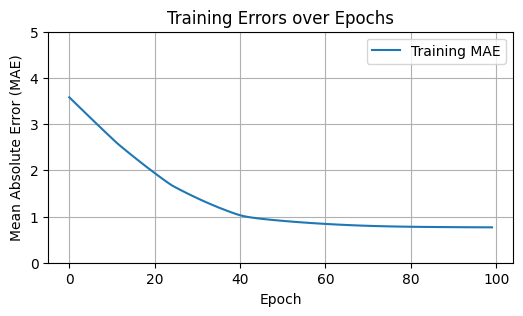

100%|██████████| 100/100 [00:28<00:00,  3.46it/s]

MatrixFactorizationModel
Test MAE: 0.8208631873130798
Test RMSE: 1.0283559560775757
Elapsed time: 28.918211460113525


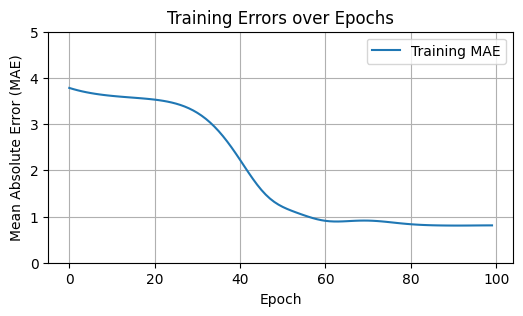

100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

MatrixFactorizationWithBiasModel
Test MAE: 0.7734430432319641
Test RMSE: 0.9605371356010437
Elapsed time: 46.5794575214386


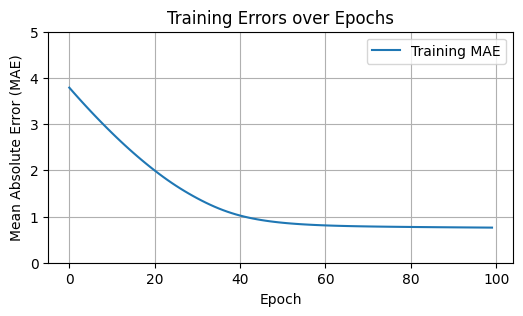

100%|██████████| 100/100 [01:09<00:00,  1.44it/s]

NeuralCollaborativeFilteringModel
Test MAE: 0.7279818058013916
Test RMSE: 0.9148170351982117
Elapsed time: 69.49877715110779


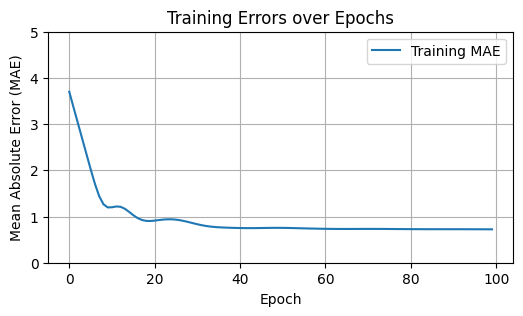

100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


NCFWithoutBiasModel
Test MAE: 0.7429745197296143
Test RMSE: 0.9339159727096558
Elapsed time: 51.698540925979614


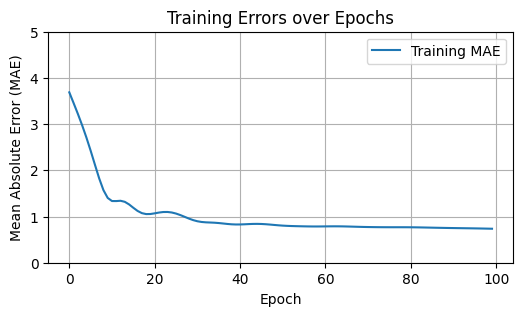

In [23]:
model = BiasOnlyModel(num_users, num_movies, embedding_size=5)
train_and_evaluate(model, data)
model = MatrixFactorizationModel(num_users, num_movies, embedding_size=5)
train_and_evaluate(model, data)
model = MatrixFactorizationWithBiasModel(num_users, num_movies, embedding_size=5)
train_and_evaluate(model, data)
model = NeuralCollaborativeFilteringModel(num_users, num_movies, embedding_size=5)
train_and_evaluate(model, data)
model = NCFWithoutBiasModel(num_users, num_movies, embedding_size=5)
train_and_evaluate(model, data)


### With Dataloader

In [ ]:
class MovieLensDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe[['userId', 'movieId']].values
        self.ratings = dataframe['rating'].values.astype(np.float32)

        # It is faster (at least 2x) to use numpy arrays instead of a dataframe as below
        # and access the data in __getitem__ using iloc
        #self.data = dataframe[['userId', 'movieId']]
        #self.ratings = dataframe['rating']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.LongTensor(self.data[idx]), torch.FloatTensor([self.ratings[idx]])

In [ ]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.1)

# Initialize dataset and data loaders
train_dataset = MovieLensDataset(train_data)
test_dataset = MovieLensDataset(test_data)

n_samples = len(train_data)
batch_size = 1024
# Note: Setting batch_size larger values will decrease the time of a single epoch but after
# a certain value it does not further decrease. In the extreme even if you set batch_size to n_samples
# the running time of a single epoch will still be significant. This is probably because of the overhead
# caused by dataset loader.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Initialize the model and optimizer
num_users = len(user_ids)
num_movies = len(movie_ids)
model = MatrixFactorization(num_users, num_movies, embedding_size=10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

# Training loop
num_epochs = 10

import time
start = time.time()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    absolute_errors = []
    for batch_idx, (X, y) in enumerate(train_loader):

        X = X.to(device)
        y = y.to(device)
        predictions = model(X)
        loss = criterion(predictions, y.squeeze())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        absolute_errors.extend(torch.abs(predictions - y.squeeze()).tolist())

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")
    print(f"Train MAE: {np.mean(absolute_errors)}")


end = time.time()
print("Elapsed time:", end - start)


Using device cuda.
Epoch 1/10, Loss: 20.467501174319874
Train MAE: 3.869186068629986
Epoch 2/10, Loss: 16.924936573071914
Train MAE: 3.6658172281302916
Epoch 3/10, Loss: 15.361764957688072
Train MAE: 3.5474201437089294
Epoch 4/10, Loss: 13.43683146129955
Train MAE: 3.2929147746120337
Epoch 5/10, Loss: 10.171332882751118
Train MAE: 2.72267129136541
Epoch 6/10, Loss: 6.937358105724508
Train MAE: 2.0840590283917386
Epoch 7/10, Loss: 4.9165180330926725
Train MAE: 1.6725891034308744
Epoch 8/10, Loss: 3.731996236877008
Train MAE: 1.4241787698004253
Epoch 9/10, Loss: 2.9928122379563074
Train MAE: 1.2635202259072942
Epoch 10/10, Loss: 2.5022550215775317
Train MAE: 1.1534300081820639
Elapsed time: 146.3814103603363


In [ ]:
# Evaluation on the test set
test_loss = 0.0
absolute_errors = []
with torch.no_grad():
    for batch_idx, (X, y) in enumerate(test_loader):
        predictions = model(X)
        loss = criterion(predictions, y.squeeze())
        test_loss += loss.item()
        absolute_errors.extend(torch.abs(predictions - y.squeeze()).tolist())

print(f"Test Loss: {test_loss / len(test_loader)}")
print(f"Test MAE: {np.mean(absolute_errors)}")

Test Loss: 1.7731850219395342
Test MAE: 0.8969225770291805


### What is going on under the hood?

Some explanations in order to understand what is going on during the computation.

In [ ]:
criterion = nn.MSELoss()
num_users = len(user_ids)
num_movies = len(movie_ids)
model = MatrixFactorizationModel(num_users, num_movies, embedding_size=5)
n_samples = len(train_data)
X = torch.tensor(train_data[['userId', 'movieId']].values)
y = torch.tensor(train_data['rating'].values.astype(np.float32))
permutation = torch.randperm(n_samples)
indices = permutation[0:0+32]
batch_X, batch_y = X[indices], y[indices]
predictions = model(batch_X)
loss = criterion(predictions, batch_y)

X contains the indices of pairs of users and movies.

In [ ]:
X[:3]

tensor([[ 42, 343],
        [302, 757],
        [501,  71]])

Select a set of users and movies

In [ ]:
uidx = torch.tensor([0,1,2])
iidx = torch.tensor([6,7,8])

In [ ]:
user_emb = model.user_embedding(uidx)
user_emb

tensor([[-1.0025, -0.4543, -0.7436,  1.6553,  1.9770],
        [-0.1971,  0.0846, -0.6548,  1.4419,  1.4326],
        [-0.8921, -1.0224, -0.3187,  0.2523,  0.4210]],
       grad_fn=<EmbeddingBackward0>)

In [ ]:
movie_emb = model.movie_embedding(iidx)
movie_emb

tensor([[-0.0895, -1.1188, -0.7012,  1.8861,  0.7449],
        [-0.8070, -0.8636, -0.1842,  0.4362,  1.6826],
        [-0.1349, -0.9455, -1.8755,  0.2066,  1.1307]],
       grad_fn=<EmbeddingBackward0>)

Find their dot product by first element-wise multiplication then sum along the x dimension

In [ ]:
mul = user_emb * movie_emb
mul

tensor([[ 0.0897,  0.5083,  0.5214,  3.1219,  1.4727],
        [ 0.1591, -0.0731,  0.1206,  0.6290,  2.4105],
        [ 0.1204,  0.9667,  0.5977,  0.0521,  0.4760]], grad_fn=<MulBackward0>)

In [ ]:
torch.sum(mul, dim=1)

tensor([5.7140, 3.2461, 2.2128], grad_fn=<SumBackward1>)

You can check that

In [ ]:
sum([ 0.0897,  0.5083,  0.5214,  3.1219,  1.4727])

5.7139999999999995